#  Decision Tree on Titanic Data
In this kernal we will take look at Decision Trees using Titanic dataset.The main aspects covered are:
1. Learning from the data with Decision Trees
2. Dataset exploration and processing
3. Relevant features for Decision Trees
4. Gini Impurity
5. Finding best tree depth with the help of cross-validation
6. Generating and visualising the final model

## What is a Decision Tree? how does it work?
Decision tree is a type of supervised learning algorithm(having a pre-defined target variable) that is mostly used in classification problems. It works for both categorical and continuous input and output variables. In this technique, we split the population or sample into two or more homogeneous sets (or sub-populations) based on most significant splitter / differentiator in input variables.

## Types of Decision Trees
Types of decision tree is based on the type of target variable we have.it can be of two types:

__1. Categorical Variable Decision Tree:__Decision Tree which has categorical target variable then it called as categorical variable decision tree.

__2. Continuous Variable Decision Tree:__Decision Tree has continuous target variable then it is called as Continuous Variable Decision Tree.
_Example_:- Let’s say we have a problem to predict whether a customer will pay his renewal premium with an insurance company (yes/ no). Here we know that income of customer is a significant variable but insurance company does not have income details for all customers. Now, as we know this is an important variable, then we can build a decision tree to predict customer income based on occupation, product and various other variables. In this case, we are predicting values for continuous variable.

## Important Terminology related to Decision Trees
Lets look at the basic terminology used with Decision trees:

__1 .RootNode:__It represents entire population or sample and this further gets divided into two or more homogeneous sets.

__2.Splitting:__It is a process of dividing a node into two or more sub-nodes.

__3.Decision Node:__When a sub-node splits into further sub-nodes, then it is called decision node.

__4.Leaf/ Terminal Node:__Nodes do not split is called Leaf or Terminal node.

![title](dt1.png)

__5.Pruning:__ When we remove sub-nodes of a decision node, this process is called pruning. You can say opposite process of splitting.

__6.Branch / Sub-Tree:__ A sub section of entire tree is called branch or sub-tree.

__7.Parent and Child Node:__ A node, which is divided into sub-nodes is called parent node of sub-nodes where as sub-nodes are the child of parent node.

## Advantages
__1.Ease to Understand:__ Decision tree output is very east to understand.It does not require any statistical knowledge.

__2.Useful in Data exploration:__ it is fastest way to identify significant variables.with decision trees we can create new variables/features that has better power to predict target variable.

__3.Less data cleaning required:__It requires less data cleaning compared to some other modeling techniques. It is not influenced by outliers and missing values to a fair degree.

__4.Data type is not a constraint:__It can handle both numerical and categorical variables

## Disadvantages
__1.Over fitting:__ Over fitting is one of the most practical difficulty for decision tree model. This problem get solved by setting constraints on model parameters.\

__2.Not fit for continuous variables:__ While working with continuous numerical variables, decision tree looses information when it categorizes variables in different categories.

After this short introduction to Decision Trees and their place in Machine Learning, let's see how to apply them for the Titanic challenge. First, we're going to prepare the dataset and discuss the most relevant features. We'll then find the best tree depth to avoid over-fitting, generate the final model, and explain how to visualise the resulting tree.

## Preparing the Titanic dataset
For the Titanic challenge we need to guess wheter the individuals from the test dataset had survived or not. But for our current purpose let's also find out what can the data tell us about the shipwreck with the help of a Classification Tree. Let's load the data and get an overview.

In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import graphviz
#import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from IPython.display import Image
# from PIL import Image, ImageDraw, ImageFont

In [2]:
# Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)


Converting usefull columns to a dataset with numerical values by sorting them into groups

In [4]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don',
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

## Visualising processed data

In [5]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [6]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


### Heatmap
This heatmap is very useful as an initial observation because you can easily get an idea of the predictive value of each feature.the value of the heat map is between (-1,0) and (0,-1)
as the value increases the corelation between the atributes increases.

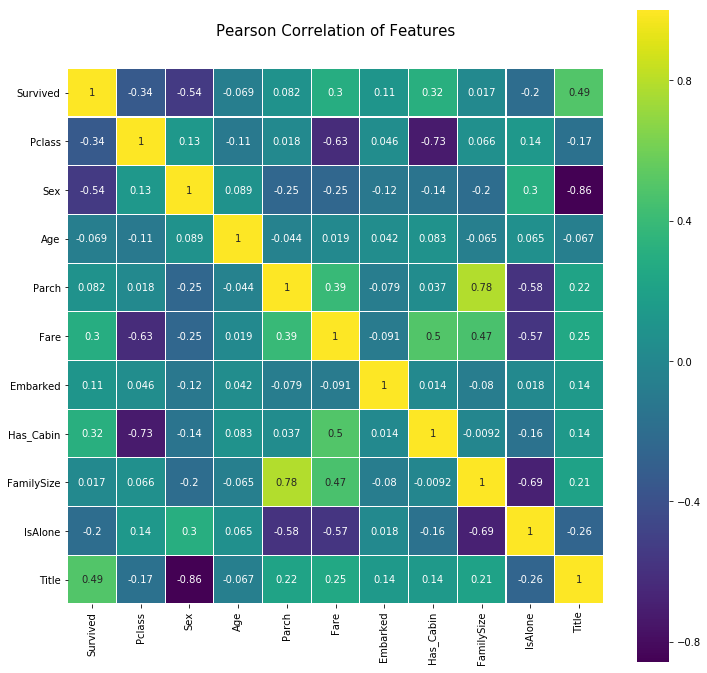

In [7]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [8]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [9]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [10]:
# Let's use our 'original_train' dataframe to check the sex distribution for each title.
# We use copy() again to prevent modifications in out original_train dataset
title_and_sex = original_train.copy()[['Name', 'Sex']]

# Create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

# Map 'Sex' as binary feature
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
# title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Sex is a binary feature, this metrics grouped by the Title feature represent:
    # MEAN: percentage of men
    # COUNT: total observations
    # SUM: number of men

## How does a tree decide where to split?
The decision of making strategic splits heavily affects a tree’s accuracy. The decision criteria is different for classification and regression trees.

Decision trees use multiple algorithms to decide to split a node in two or more sub-nodes. The creation of sub-nodes increases the homogeneity of resultant sub-nodes. In other words, we can say that purity of the node increases with respect to the target variable. Decision tree splits the nodes on all available variables and then selects the split which results in most homogeneous sub-nodes.

The algorithm selection is also based on type of target variables. Let’s look at the four most commonly used algorithms in decision tree:

### Gini Index
Gini index says, if we select two items from a population at random then they must be of same class and probability for this is 1 if population is pure.

1. It works with categorical target variable “Success” or “Failure”.
2. It performs only Binary splits
3. Higher the value of Gini higher the homogeneity.
4. CART (Classification and Regression Tree) uses Gini method to create binary splits.

__Steps to Calculate Gini for a split__

1. Calculate Gini for sub-nodes, using formula sum of square of probability for success and failure (p^2+q^2).
2. Calculate Gini for split using weighted Gini score of each node of that split

In [11]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [12]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [13]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))


Max Depth  Average Accuracy
        1          0.782285
        2          0.799189
        3          0.828277
        4          0.819288
        5          0.824919
        6          0.808127
        7          0.801386
        8          0.811498
        9          0.811536
       10          0.809276


In [14]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
# submission.to_csv('submission.csv', index=False)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
# with open("tree1.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)
# graphviz.Source("tree1.dot") .view() 

#  Code to check available fonts and respective paths
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

![title](tree1.png)